In [731]:
import numpy as np
from scipy.linalg import sqrtm 
import networkx as nx
from networkx.algorithms.community.modularity_max import greedy_modularity_communities
import community.community_louvain as cl
import matplotlib.pyplot as plt
from matplotlib import animation
%matplotlib inline
from IPython.display import HTML

In [732]:
def draw_kkl(nx_G, label_map, node_color, pos=None, **kwargs):
    fig, ax = plt.subplots(figsize=(10,10))
    if pos is None:
        pos = nx.spring_layout(nx_G, k=5/np.sqrt(nx_G.number_of_nodes()))

    nx.draw(
        nx_G, pos, with_labels=label_map is not None, 
        labels=label_map, 
        node_color=node_color, 
        ax=ax, **kwargs)

## Zachary's Karate Club

We are going to try and predict the community labels of this graph. 

In [733]:
g = nx.karate_club_graph()

In [734]:
g.number_of_nodes(), g.number_of_edges()

(34, 78)

We find the Louvain communities of the graph which should split the graph into 4 communities.

In [735]:
partition = cl.best_partition(g)
unique_values = set(partition.values())
communities = []

for value in unique_values:
  current_frozenset = frozenset()
  for key, data_value in partition.items():
    if data_value == value:
      current_frozenset = current_frozenset.union({key})
  communities.append(current_frozenset)

print(communities)

[frozenset({0, 1, 2, 3, 7, 11, 12, 13, 17, 19, 21}), frozenset({16, 4, 5, 6, 10}), frozenset({23, 24, 25, 27, 28, 31}), frozenset({32, 33, 8, 9, 14, 15, 18, 20, 22, 26, 29, 30})]


To label the communities we use one-hot encoding.

In [736]:
colors = np.zeros(g.number_of_nodes())
for i, com in enumerate(communities):
    colors[list(com)] = i

n_classes = np.unique(colors).shape[0]
# one hot encoding labels
labels = np.eye(n_classes)[colors.astype(int)]
print(labels)

[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]]


In [737]:
club_labels = nx.get_node_attributes(g,'club')

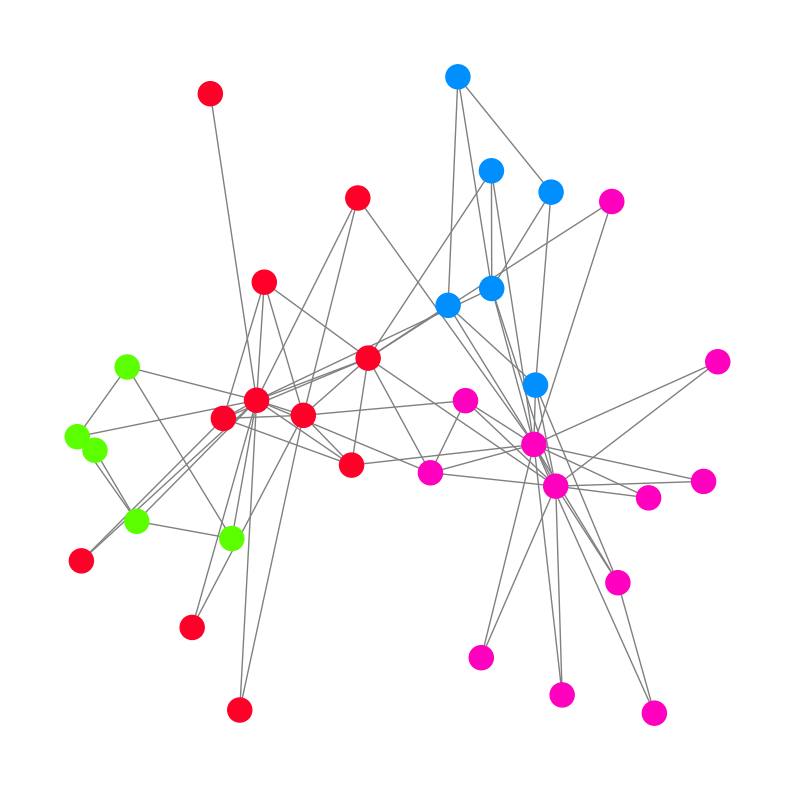

In [738]:
_ = draw_kkl(g, None, colors, cmap='gist_rainbow', edge_color='gray')

We visualize with the node numbers for clarity

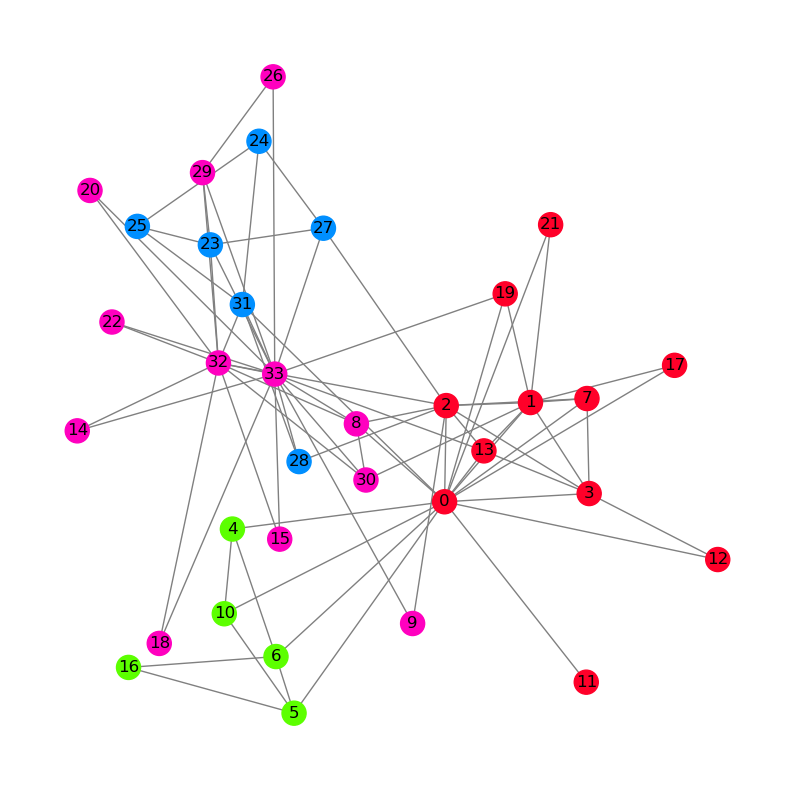

In [739]:
fig, ax = plt.subplots(figsize=(10,10))
pos = nx.spring_layout(g, k=5/np.sqrt(g.number_of_nodes()))
kwargs = {"cmap": 'gist_rainbow', "edge_color":'gray'}
nx.draw(
    g, pos, with_labels=club_labels,
    node_color=colors, 
    ax=ax, **kwargs)

# Graph Convolutions
We somewhow need to generalize the ideas of convolution to graph. That is each layer of the network must aggregate features of it's neighbourhood. This propagates node features along it's neighbourhoods so that node embeddings can be learnt independently. First we find the adjacency matrix $A$ which is the standard adjacency matrix.

In [740]:
# Adjacency matrix
A = nx.adjacency_matrix(g, weight=1)
A.toarray()

array([[0, 1, 1, ..., 1, 0, 0],
       [1, 0, 1, ..., 0, 0, 0],
       [1, 1, 0, ..., 0, 1, 0],
       ...,
       [1, 0, 0, ..., 0, 1, 1],
       [0, 0, 1, ..., 1, 0, 1],
       [0, 0, 0, ..., 1, 1, 0]])

Notice if we multiply any node embeddings vector with this adjacency array it should give us the sum of the embeddings of the nodes connected to the each node. This however has a few deficiencies. 
1. This fails to propagate the embeddings/feature vector of the node itself.
2. For nodes with higher degrees it gives us bigger values which is undesirable as they will dominate over lower degree nodes. Thus giving degree an incredible amount of influence. This is undesirable as we want to preserve both node embeddings and larger graph structures equally.

To mitigate this we find the normalized form of the adjacency matrix 
$$\hat{A} = \tilde{D}^{-\frac{1}{2}} \tilde{A}\tilde{D}^{-\frac{1}{2}}$$ 

In [741]:
A_tilde = A + np.eye(g.number_of_nodes()) # add self-connections
A_tilde

array([[1., 1., 1., ..., 1., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 1., 0.],
       ...,
       [1., 0., 0., ..., 1., 1., 1.],
       [0., 0., 1., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.]])

where, 
$$\tilde{A} = A + I$$ 
Which adds self loops thus during passing information the information of the node itself is not lost. Addressing (1)

In [742]:
D_tilde = np.zeros_like(A_tilde)
np.fill_diagonal(D_tilde, np.asarray(A_tilde.sum(axis=1)).flatten())
print(D_tilde)

D_tilde_invroot = np.linalg.inv(sqrtm(D_tilde))
D_tilde_invroot

[[17.  0.  0. ...  0.  0.  0.]
 [ 0. 10.  0. ...  0.  0.  0.]
 [ 0.  0. 11. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ...  7.  0.  0.]
 [ 0.  0.  0. ...  0. 13.  0.]
 [ 0.  0.  0. ...  0.  0. 18.]]


array([[0.24253563, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.31622777, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.30151134, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.37796447, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.2773501 ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.23570226]])


$$\tilde{D}^{-\frac{1}{2}}$$ 
is the inverse square root of the degrees of each node along the diagonal. 

This normalizes the values individually as, 
$$\hat{A}_{i,j} = \frac{1}{\sqrt{\tilde{d}_i\tilde{d}_j}}\tilde{A}_{i,j} $$
where, $$d_i\ and\ d_j$$ are the neighbourhood sizes of the nodes being connected.
This allows us to normalize along both rows and columns. Thus addressing (2).
Finally we get our improved Adjacency matrix.

In [743]:

A_hat = D_tilde_invroot @ A_tilde @ D_tilde_invroot
A_hat

array([[0.05882353, 0.0766965 , 0.07312724, ..., 0.09166985, 0.        ,
        0.        ],
       [0.0766965 , 0.1       , 0.09534626, ..., 0.        , 0.        ,
        0.        ],
       [0.07312724, 0.09534626, 0.09090909, ..., 0.        , 0.0836242 ,
        0.        ],
       ...,
       [0.09166985, 0.        , 0.        , ..., 0.14285714, 0.10482848,
        0.08908708],
       [0.        , 0.        , 0.0836242 , ..., 0.10482848, 0.07692308,
        0.06537205],
       [0.        , 0.        , 0.        , ..., 0.08908708, 0.06537205,
        0.05555556]])

# Input features
Since no node features are known we use identity matrix, this maps each node to a column of learnable parameters.

In [744]:
X = np.eye(g.number_of_nodes()) 
X

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

# Helper Functions
Here we use some helper functions for our network. 

### Xavier Glorot-Bengio Initialization
According to a blogpost by the author of the original paper. This initialization of weights makes it orthogonal which aids training.

In [745]:
# Xavier Glorot Initialization
def glorot_init(nin, nout):
    sd = np.sqrt(6.0 / (nin + nout))
    return np.random.uniform(-sd, sd, size=(nin, nout))

### Cross Entropy Loss
We use the standard cross entropy loss function as our loss. Which is $$\begin{align}H(q, p) &= -\sum(q_i \times log(p_i))\\ where, q_i &-> \text{true probability for class}\ i\\ p_i &-> \text{predicted probability for class}\ i\end{align}$$


In [746]:
# cross entropy
def xent(pred, labels):
    return -np.log(pred)[np.arange(pred.shape[0]), np.argmax(labels, axis=1)]

### RelU
Standard implementaion of the RelU function

In [747]:
def leaky_relu(x):
  return np.maximum(0.01*x, x)
def leaky_d_relu(x):
  dx = np.ones_like(x)
  dx[x<0] = 0.01
  return dx

### Gradient Desecent Helper
We use a helper class to propagate Gradients down the layers. 

In [748]:
class GradDescentOptim():
    def __init__(self, lr):
        self.lr = lr
        self._y_pred = None
        self._y_true = None
        self._out = None
        self.bs = None
        self.train_nodes = None
        
    def __call__(self, y_pred, y_true, train_nodes=None):
        self.y_pred = y_pred
        self.y_true = y_true
        
        if train_nodes is None:
            self.train_nodes = np.arange(y_pred.shape[0])
        else:
            self.train_nodes = train_nodes
            
        self.bs = self.train_nodes.shape[0]
        
    @property
    def out(self):
        return self._out
    
    @out.setter
    def out(self, y):
        self._out = y
    

## Layer-wise propagation rule
$$ H^{(l+1)} = \sigma(\tilde{D}^{-\frac{1}{2}} \tilde{A}\tilde{D}^{-\frac{1}{2}}H^{(l)}W^{(l)})$$
$W^{(l)}$ -> is a layer specific trainable weight matrix.

$\sigma(.)$ -> denotes an activation function. 

$H^{(l)}$ denotes the matrix of activations in the $l^{th}$ layer; $H^{0}=X$.


In [749]:
class GCNLayer():
    def __init__(self, n_inputs, n_outputs, activation=None, act=None, name=''):
        # number of input features
        self.n_inputs = n_inputs
        # number of output features
        self.n_outputs = n_outputs
        # learnable parameter matrix
        self.W = glorot_init(self.n_outputs, self.n_inputs)
        # activation function
        self.activation = activation
        self.name = name
        self.act = act
        
    def __repr__(self):
        return f"GCN: W{'_'+self.name if self.name else ''} ({self.n_inputs}, {self.n_outputs})"
        
    def forward(self, A, X, W=None):
        self._A = A
        self._X = (A @ X).T 
        
        if W is None:
            W = self.W
        
        H = W @ self._X  
        if self.activation is not None:
            H = self.activation(H)
        self._H = H 
        return self._H.T
    
    def backward(self, optim, update=True):
        if self.act == "leaky relu":
            drelu = leaky_d_relu(self._H.T)
            d2 = optim.out * drelu
        else:
            # derivative of the tan function
            dtanh = 1 - np.asarray(self._H.T)**2 
            # get the gradient from the next layer and move it back through it's own activation layer
            d2 = np.multiply(optim.out, dtanh)  
        
        # multiply with it's weights and convolutions to pass onto previous layer
        self.grad = self._A @ d2 @ self.W 
        optim.out = self.grad
        
        # delta of weights normalized by batch size
        dW = np.asarray(d2.T @ self._X.T) / optim.bs 
        
        if update:
            self.W -= (dW) * optim.lr 
        
        return dW


# Output Layer
Since it is a classification problem we need to find class probabilites. Softmax is suited for this according to [4] Simplifying Graph Convolutional Networks

In [750]:

    
class SoftmaxLayer():
    def __init__(self, n_inputs, n_outputs, name=''):
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        self.W = glorot_init(self.n_outputs, self.n_inputs)
        self.b = np.zeros((self.n_outputs, 1))
        self.name = name
        self._X = None # Used to calculate gradients
        
    def __repr__(self):
        return f"Softmax: W{'_'+self.name if self.name else ''} ({self.n_inputs}, {self.n_outputs})"
    
    def sftmax(self, proj):
        exps = np.exp(proj)
        return exps / np.sum(exps, axis=0, keepdims=True)
        
    def forward(self, X, W=None, b=None):
        self._X = X.T
        if W is None:
            W = self.W
        if b is None:
            b = self.b

        proj = np.asarray(W @ self._X) + b 
        return self.sftmax(proj).T 
    
    def backward(self, optim, update=True):
        # should take in optimizer, update its own parameters and update the optimizer's "out"
        # Mask out nodes not used in training
        train_mask = np.zeros(optim.y_pred.shape[0])
        train_mask[optim.train_nodes] = 1
        train_mask = train_mask.reshape((-1, 1))
        
        # derivative of loss w.r.t. activation (pre-softmax)
        d1 = np.asarray((optim.y_pred - optim.y_true)) # calculating the difference. 
        d1 = np.multiply(d1, train_mask) # applying mask
        
        self.grad = d1 @ self.W # compute gradient with respect to the weights and biases usin
        optim.out = self.grad
        
        dW = (d1.T @ self._X.T) / optim.bs 
        db = d1.T.sum(axis=1, keepdims=True) / optim.bs 
                
        
        if update:   
            self.W -= (dW) * optim.lr
            self.b -= db.reshape(self.b.shape) * optim.lr
        
        return dW, db.reshape(self.b.shape)

# The Model
Finally we initialize the input layer as a GCN layer, Add hidden layers accordingly and keep the softmax output layer. $$\hat{Y}_{GCN} = softmax(\tilde{D}^{-\frac{1}{2}} \tilde{A}\tilde{D}^{-\frac{1}{2}}H^{(l-1)}W^{(l)})$$

This should in theory perform semi supervised learning that is given labels of a single node of a single class it should be able to extract the communities using graph structures. 

In [751]:
class GCNNetwork():
    def __init__(self, n_inputs, n_outputs, n_layers, hidden_sizes, activation, act=None, seed=0):
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        self.n_layers = n_layers
        self.hidden_sizes = hidden_sizes
        self.activation = activation
        self.act = act
        
        np.random.seed(seed)
        
        self.layers = list()
        # Input layer
        gcn_in = GCNLayer(n_inputs, hidden_sizes[0], activation, act, name='in')
        self.layers.append(gcn_in)
        
        # Hidden layers
        for layer in range(n_layers):
            gcn = GCNLayer(self.layers[-1].W.shape[0], hidden_sizes[layer], activation, act, name=f'h{layer}')
            self.layers.append(gcn)
            
        # Output layer
        sm_out = SoftmaxLayer(hidden_sizes[-1], n_outputs, name='sm')
        self.layers.append(sm_out)
        
    def __repr__(self):
        return '\n'.join([str(l) for l in self.layers])
    
    def embedding(self, A, X):
        # Loop through all GCN layers
        H = X
        for layer in self.layers[:-1]:
            H = layer.forward(A, H)
        return np.asarray(H)
    
    def forward(self, A, X):
        # GCN layers
        H = self.embedding(A, X)
        
        # Softmax
        p = self.layers[-1].forward(H)
        
        return np.asarray(p)

In [752]:
gcn_model = GCNNetwork(
    n_inputs = g.number_of_nodes(), 
    n_outputs = n_classes, 
    n_layers=2,
    hidden_sizes=[16, 2],
    # activation= np.tanh, 
    activation=leaky_relu,
    act="leaky relu",
    seed=100,
)
gcn_model

GCN: W_in (34, 16)
GCN: W_h0 (16, 16)
GCN: W_h1 (16, 2)
Softmax: W_sm (2, 4)

In [753]:
y_pred = gcn_model.forward(A_hat, X)
embed = gcn_model.embedding(A_hat, X)
xent(y_pred, labels).mean()

1.3919561049372866

# Visualizing the initial two dimensional embedding space

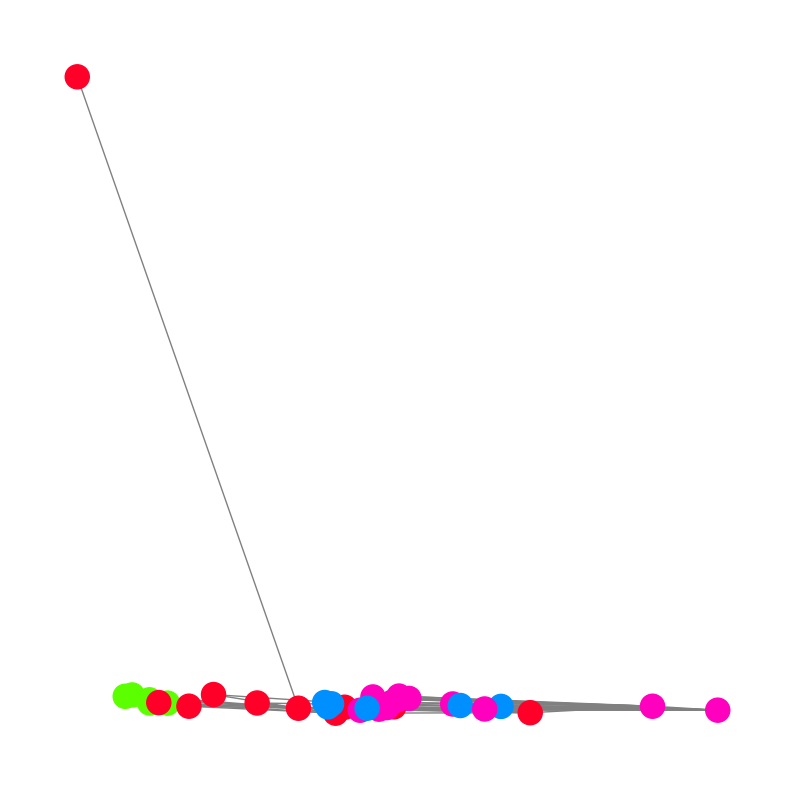

In [754]:
pos = {i: embed[i,:] for i in range(embed.shape[0])}
_ = draw_kkl(g, None, colors, pos=pos, cmap='gist_rainbow', edge_color='gray')

# Training
Here we select a single traning node from each of our graph communities and mask out others we initialize the gradient descent helper and perform traning until loss isn't being minimized for 50 steps. 

In [755]:
train_nodes = np.array([0, 4, 31, 8])
test_nodes = np.array([i for i in range(labels.shape[0]) if i not in train_nodes])
opt = GradDescentOptim(lr=2e-2)

In [756]:
embeds = list()
accs = list()
train_losses = list()
test_losses = list()

loss_min = 1e6
es_iters = 0
es_steps = 50


for epoch in range(15000):
    
    y_pred = gcn_model.forward(A_hat, X)

    opt(y_pred, labels, train_nodes)

    for layer in reversed(gcn_model.layers):
        layer.backward(opt, update=True)
        
    embeds.append(gcn_model.embedding(A_hat, X))
    
    # Accuracy for non-training nodes
    acc = (np.argmax(y_pred, axis=1) == np.argmax(labels, axis=1))[
        [i for i in range(labels.shape[0]) if i not in train_nodes]
    ]
    accs.append(acc.mean())
    
    loss = xent(y_pred, labels)
    loss_train = loss[train_nodes].mean()
    loss_test = loss[test_nodes].mean()
    
    train_losses.append(loss_train)
    test_losses.append(loss_test)
    
    if loss_test < loss_min:
        loss_min = loss_test
        es_iters = 0
    else:
        es_iters += 1
        
    if es_iters > es_steps:
        print("Early stopping!")
        break
    
    if epoch % 100 == 0:
        print(f"Epoch: {epoch+1}, Train Loss: {loss_train:.3f}, Test Loss: {loss_test:.3f}")
        
train_losses = np.array(train_losses)
test_losses = np.array(test_losses)

Epoch: 1, Train Loss: 1.393, Test Loss: 1.392
Epoch: 101, Train Loss: 1.385, Test Loss: 1.387
Epoch: 201, Train Loss: 1.376, Test Loss: 1.381
Epoch: 301, Train Loss: 1.364, Test Loss: 1.374
Epoch: 401, Train Loss: 1.348, Test Loss: 1.365
Epoch: 501, Train Loss: 1.324, Test Loss: 1.351
Epoch: 601, Train Loss: 1.287, Test Loss: 1.328
Epoch: 701, Train Loss: 1.228, Test Loss: 1.292
Epoch: 801, Train Loss: 1.145, Test Loss: 1.239
Epoch: 901, Train Loss: 1.054, Test Loss: 1.182
Epoch: 1001, Train Loss: 0.967, Test Loss: 1.136
Epoch: 1101, Train Loss: 0.896, Test Loss: 1.098
Epoch: 1201, Train Loss: 0.847, Test Loss: 1.066
Epoch: 1301, Train Loss: 0.807, Test Loss: 1.045
Epoch: 1401, Train Loss: 0.773, Test Loss: 1.030
Epoch: 1501, Train Loss: 0.742, Test Loss: 1.017
Epoch: 1601, Train Loss: 0.710, Test Loss: 1.005
Epoch: 1701, Train Loss: 0.675, Test Loss: 0.990
Epoch: 1801, Train Loss: 0.634, Test Loss: 0.971
Epoch: 1901, Train Loss: 0.584, Test Loss: 0.948
Epoch: 2001, Train Loss: 0.524, 

We plot the test and training loss convergence.

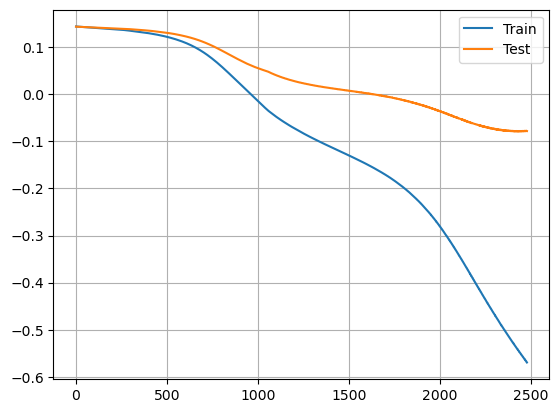

In [757]:
fig, ax = plt.subplots()
ax.plot(np.log10(train_losses), label='Train')
ax.plot(np.log10(test_losses), label='Test')
ax.legend()
ax.grid()

Final graph after we have found the communinties. We can see that the network learns embeddings such that it can differentiate among the different communities in a 2d space

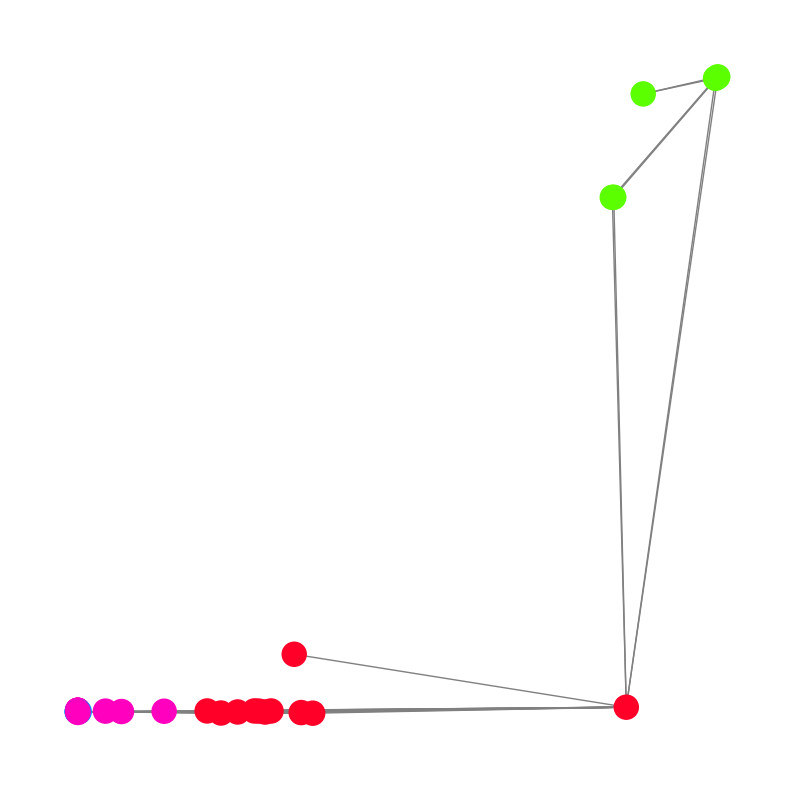

In [758]:
pos = {i: embeds[-1][i,:] for i in range(embeds[-1].shape[0])}
_ = draw_kkl(g, None, colors, pos=pos, cmap='gist_rainbow', edge_color='gray')

In [759]:
N = 500
snapshots = np.linspace(0, len(embeds)-1, N).astype(int)

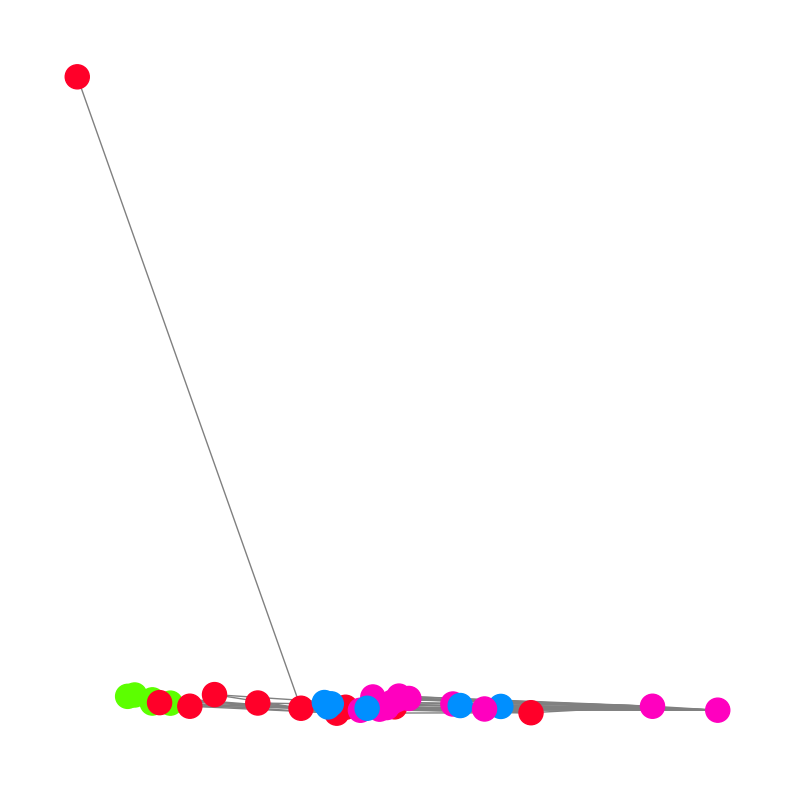

In [760]:
# Build plot
fig, ax = plt.subplots(figsize=(10, 10))
kwargs = {'cmap': 'gist_rainbow', 'edge_color': 'gray', }

def update(idx):
    ax.clear()
    embed = embeds[snapshots[idx]]
    pos = {i: embed[i,:] for i in range(embed.shape[0])}
    nx.draw(g, pos, node_color=colors, ax=ax, **kwargs)

anim = animation.FuncAnimation(fig, update, frames=snapshots.shape[0], interval=10, repeat=False)

In [761]:
HTML(anim.to_html5_video())

# References
1. https://arxiv.org/pdf/1609.02907 SEMI-SUPERVISED CLASSIFICATION WITH GRAPH CONVOLUTIONAL NETWORKS
2. https://tkipf.github.io/graph-convolutional-networks/  Graph Convolutional Networks, Thomas Kipf
3. https://www.cs.mcgill.ca/~wlh/grl_book/files/GRL_Book.pdf [Chapter 7: Theoretical Motivations Section 7.1: GNNs and Graph Convolutions]
4. https://arxiv.org/pdf/1902.07153 Simplifying Graph Convolutional Networks
5. https://www.topbots.com/graph-convolutional-networks/
6. https://blog.zakjost.com/post/gcn_citeseer/
7. https://github.com/zjost/blog_code/tree/master/gcn_numpy